In [16]:
%reload_ext autoreload
%autoreload 2

In [49]:
from GPSR_Basic import GPSR_Basic
import scipy.io as scio
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import h5py

In [2]:
device="cuda"
dtype=torch.float64

In [3]:
metadata = scio.loadmat("./recvs/PM2/Lena.mat")
x = torch.tensor(np.array(metadata["x"])[0],device=device,dtype=dtype)
y = torch.tensor(np.array(metadata["y"]),device=device,dtype=dtype)
A_recv = torch.tensor(np.array(metadata["A_recv"]),device=device,dtype=dtype)
print(x)
print(y)
print(A_recv)
error=A_recv @ x.reshape((-1,1)) - y.reshape((-1,1))
print(error)
print(abs(error).mean())

tensor([[[0.6353, 0.6275, 0.6353,  ..., 0.4627, 0.6471, 0.6392],
         [0.6314, 0.6275, 0.6235,  ..., 0.4941, 0.5294, 0.3647],
         [0.6118, 0.6078, 0.6157,  ..., 0.4157, 0.2039, 0.1882],
         ...,
         [0.2039, 0.2000, 0.2510,  ..., 0.2275, 0.2157, 0.2471],
         [0.2039, 0.2078, 0.2196,  ..., 0.2275, 0.2667, 0.3451],
         [0.1882, 0.1922, 0.1922,  ..., 0.2706, 0.3529, 0.4039]]],
       device='cuda:0', dtype=torch.float64)
tensor([[[4627.7573, 4044.9463, 3594.7773,  ..., 4343.1470, 4322.7227,
          4163.9482]]], device='cuda:0', dtype=torch.float64)
tensor([[0.2148, 0.1486, 0.2203,  ..., 1.0973, 1.0391, 0.8540],
        [0.1907, 0.1341, 0.1960,  ..., 0.9429, 0.8923, 0.7307],
        [0.1755, 0.1259, 0.1797,  ..., 0.8073, 0.7664, 0.6327],
        ...,
        [0.1789, 0.1166, 0.1829,  ..., 1.0121, 0.9604, 0.7920],
        [0.1961, 0.1304, 0.1954,  ..., 1.0158, 0.9617, 0.7878],
        [0.1945, 0.1358, 0.1973,  ..., 0.9654, 0.9171, 0.7614]],
       device='cud

In [4]:
def dct_matrix(N,device,dtype=torch.float32):
    psi=torch.zeros((N,N),device=device,dtype=dtype)
    for q in range(N):
        t=np.zeros((N,1))
        t[q,0]=1
        psi[:,q]= torch.tensor(cv2.idct(t).reshape((-1,)),device=device,dtype=dtype)
    return psi

In [ ]:
N = 128*128
W = dct_matrix(N,device,dtype)
WT = torch.inverse(W)

In [ ]:
tau=.35;
stopCri = 4;
tolA = 1.e-3;

In [68]:
names=[
    "GI",
    "Baboon",
    "Barbara",
    "Cameraman",
    "Goldhill",
    "Lena",
    "Peppers"
]
PMS = [
    "PM1",
    "PM2",
    "PM3"
]
PM_res=[]
for pm in PMS:
    res=[]
    for name in names:
        metadata = scio.loadmat("./recvs/{}/{}.mat".format(pm,name))
        x = torch.tensor(np.array(metadata["x"])[0],device=device,dtype=dtype)
        y = torch.tensor(np.array(metadata["y"]),device=device,dtype=dtype)
        A_recv = torch.tensor(np.array(metadata["A_recv"]),device=device,dtype=dtype)
        
        f = x.reshape((-1,1))
        y = y.reshape((-1,1))
        A = A_recv @ W
        hR = lambda x: A @ x
        AT = lambda x: A.T @ x
        
        [theta,theta_debias,obj_GPSR_Basic,times_GPSR_Basic,debias_s,mses_GPSR_Basic] = \
            GPSR_Basic(
              y,hR,tau,device,dtype,
                Debias=0,
                AT=AT,
                True_x=WT @ f,
                Initialization=AT(y),
                StopCriterion=stopCri,
                ToleranceA=tolA,
                ToleranceD=0.0001,
                Verbose=False
            )
        res.append((W @ theta).cpu().numpy())
        print("====================")
    PM_res.append(res)

    reducing lambda to 2.89e-03

    reducing lambda to 3.12e-03

    reducing lambda to 6.81e-03

    reducing lambda to 3.41e-03

    reducing lambda to 2.31e-06

    reducing lambda to 2.19e-06

    reducing lambda to 8.76e-03

    reducing lambda to 4.38e-03

    reducing lambda to 2.55e-06

    reducing lambda to 2.11e-06

    reducing lambda to 3.22e-02

    reducing lambda to 1.61e-02

    reducing lambda to 8.05e-03

    reducing lambda to 2.22e-06

    reducing lambda to 1.74e-04

    reducing lambda to 8.68e-05

    reducing lambda to 1.73e-06

    reducing lambda to 1.89e-04

    reducing lambda to 9.43e-05

    reducing lambda to 4.71e-05

    reducing lambda to 1.73e-06

    reducing lambda to 1.33e-04

    reducing lambda to 6.63e-05

    reducing lambda to 3.34e-06

    reducing lambda to 1.28e-04

    reducing lambda to 6.41e-05

    reducing lambda to 3.21e-05

    reducing lambda to 3.25e-06

    reducing lambda to 1.62e-06

    reducing lambda to 4.18e-02

    reduci

In [69]:
idxs=[0,1,6,4,2,3,5]
PM_res_ordered=[]
for res in PM_res:
    PM_res_ordered.append([res[i] for i in idxs])

In [83]:
f = h5py.File("./recvs/res/float64_GPSR_res.h5","w")
f.create_dataset("value", data = np.array(PM_res_ordered))
f.close()

In [95]:
f2 = h5py.File("./recvs/res/float64_GPSR_res.h5")
a=np.array(f2["value"])
f2.close()

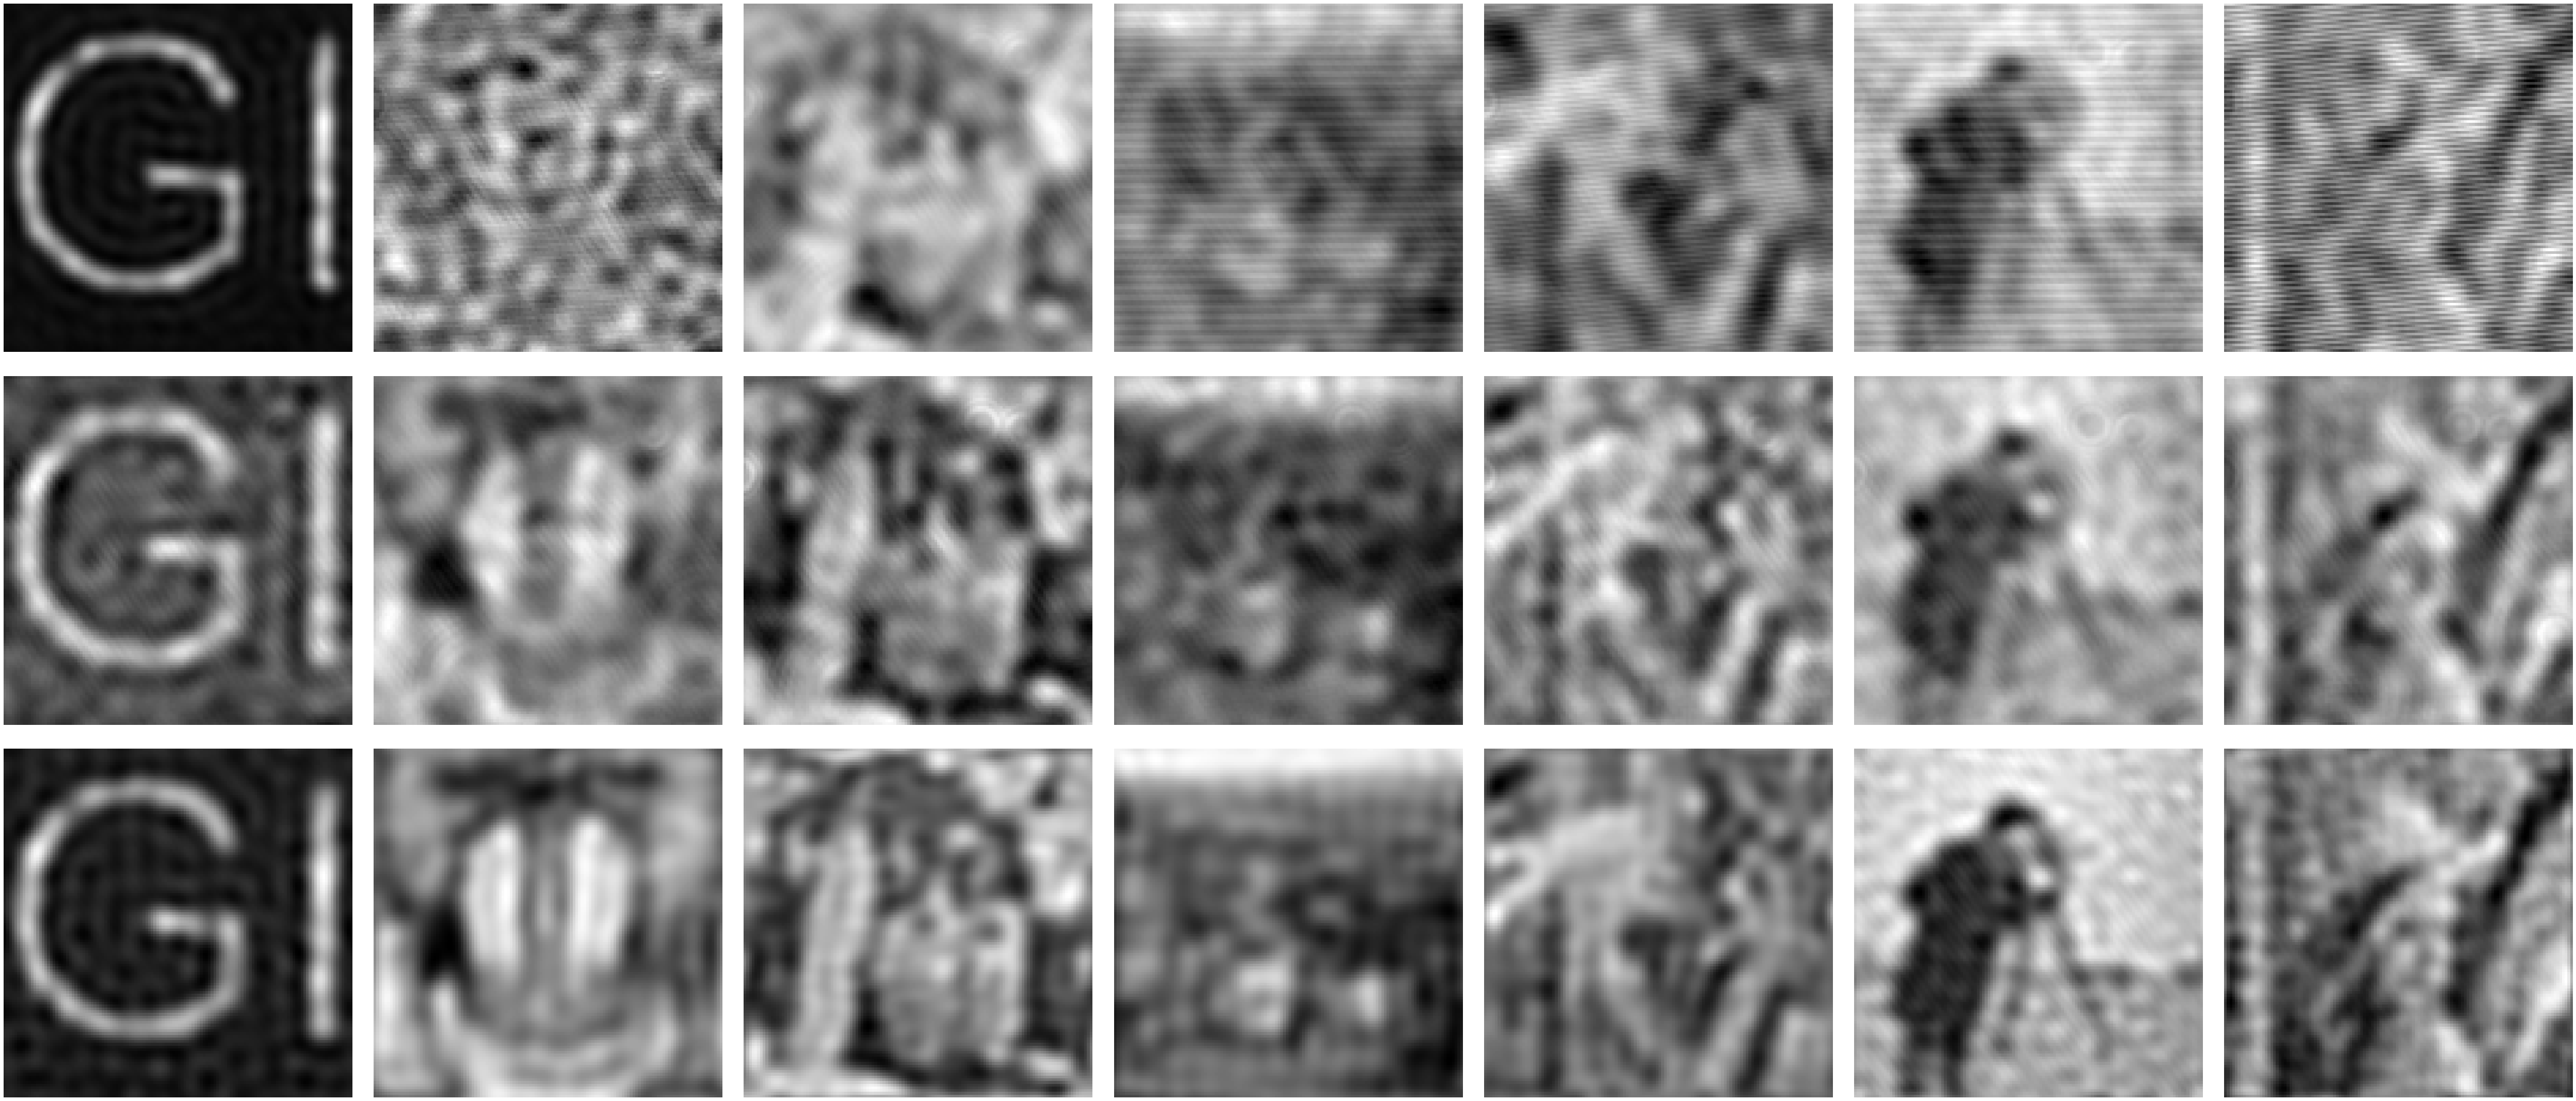

In [96]:
plt.figure(figsize=(7*10,3*10))
for i in range(7):
    plt.subplot(3,7,i+1)
    plt.imshow(a[0][i].reshape(128,128),cmap="gray")
    plt.axis("off")

    plt.subplot(3,7,i+1+7)
    plt.imshow(a[1][i].reshape(128,128),cmap="gray")
    plt.axis("off")

    plt.subplot(3,7,i+1+7*2)
    plt.imshow(a[2][i].reshape(128,128),cmap="gray")
    plt.axis("off")
    
plt.tight_layout(pad=2, h_pad=5)
# plt.savefig("./recvs/res/A_recv_GPSR_float64_res.jpg")